In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, log_loss
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
import shap
import warnings

warnings.filterwarnings("ignore")

# Load the dataset
file_path = r"C:\Users\offic\OneDrive\Masaüstü\datasets\mushroom.csv"
data = pd.read_csv(file_path)

# Data Preprocessing
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features.remove('class')

cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', num_imputer), ('scaler', scaler)]), numerical_features),
        ('cat', Pipeline([('imputer', cat_imputer), ('encoder', encoder)]), categorical_features)
    ])

X = data.drop('class', axis=1)
y = data['class']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_transformed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

# Hyperparameter Tuning
param_grid = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 6, 9]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.5, 1, 1.5]
    },
    'ExtraTrees': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [3, 4, 5]
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
}

best_params = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], cv=3, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    best_params[model_name] = grid_search.best_params_
    print(f"Best parameters for {model_name}: {best_params[model_name]}")

# Explicitly Train Models with Best Parameters
trained_models = {}
for model_name, params in best_params.items():
    print(f"Training {model_name} with best parameters...")
    if model_name == 'XGBoost':
        model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=10,
            verbose=True
        )
    else:
        model = models[model_name].set_params(**params)
        model.fit(X_train, y_train)
    trained_models[model_name] = model



Tuning RandomForest...
Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Tuning GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300}
Tuning AdaBoost...
Best parameters for AdaBoost: {'learning_rate': 1.5, 'n_estimators': 200}
Tuning ExtraTrees...
Best parameters for ExtraTrees: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Tuning SVC...
Best parameters for SVC: {'C': 10, 'degree': 5, 'kernel': 'poly'}
Tuning LogisticRegression...
Best parameters for LogisticRegression: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Training RandomForest with best parameters...
Training GradientBoosting with best parameters...
Training XGBoost with best parameters...


TypeError: fit() got an unexpected keyword argument 'early_stopping_rounds'

In [11]:
import xgboost as xgb

Training RandomForest with best parameters...
Training GradientBoosting with best parameters...
Training XGBoost with best parameters...
[0]	train-logloss:0.60544	eval-logloss:0.60681
[1]	train-logloss:0.53876	eval-logloss:0.54073
[2]	train-logloss:0.48186	eval-logloss:0.48320
[3]	train-logloss:0.44658	eval-logloss:0.44836
[4]	train-logloss:0.40843	eval-logloss:0.40960
[5]	train-logloss:0.38382	eval-logloss:0.38540
[6]	train-logloss:0.36540	eval-logloss:0.36712
[7]	train-logloss:0.33586	eval-logloss:0.33718
[8]	train-logloss:0.32415	eval-logloss:0.32545
[9]	train-logloss:0.30605	eval-logloss:0.30724
[10]	train-logloss:0.29180	eval-logloss:0.29307
[11]	train-logloss:0.27383	eval-logloss:0.27571
[12]	train-logloss:0.25721	eval-logloss:0.25925
[13]	train-logloss:0.24812	eval-logloss:0.25021
[14]	train-logloss:0.24084	eval-logloss:0.24269
[15]	train-logloss:0.23415	eval-logloss:0.23628
[16]	train-logloss:0.21972	eval-logloss:0.22185
[17]	train-logloss:0.21209	eval-logloss:0.21447
[18]	trai

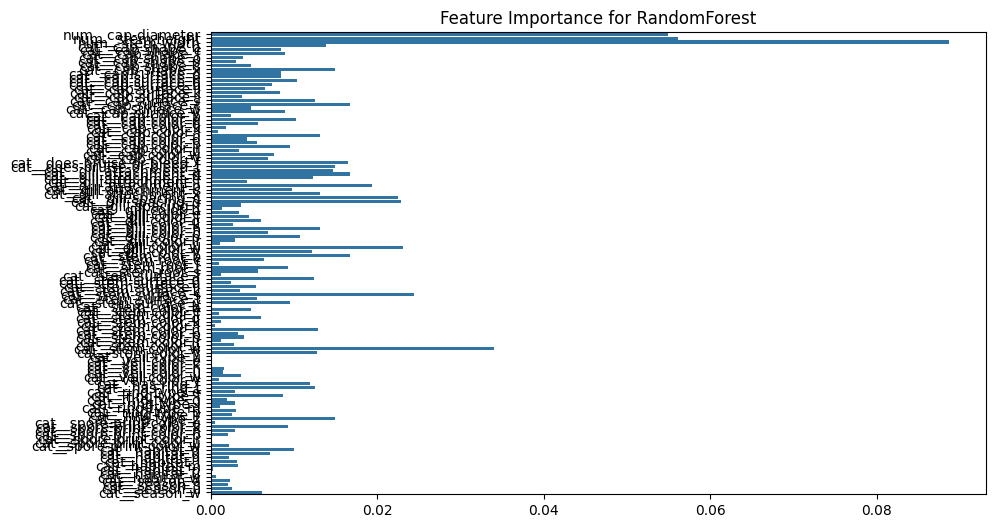


Evaluating GradientBoosting...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 1.0


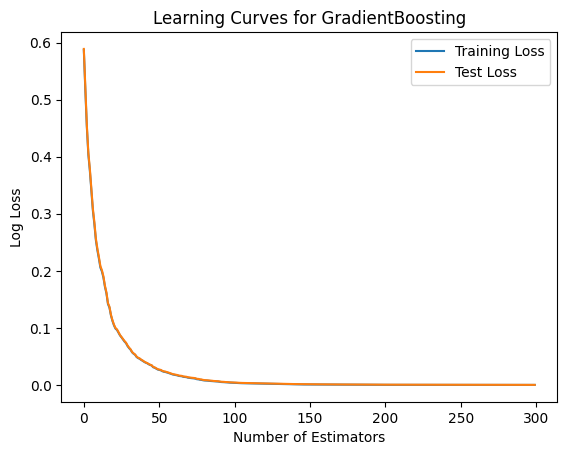

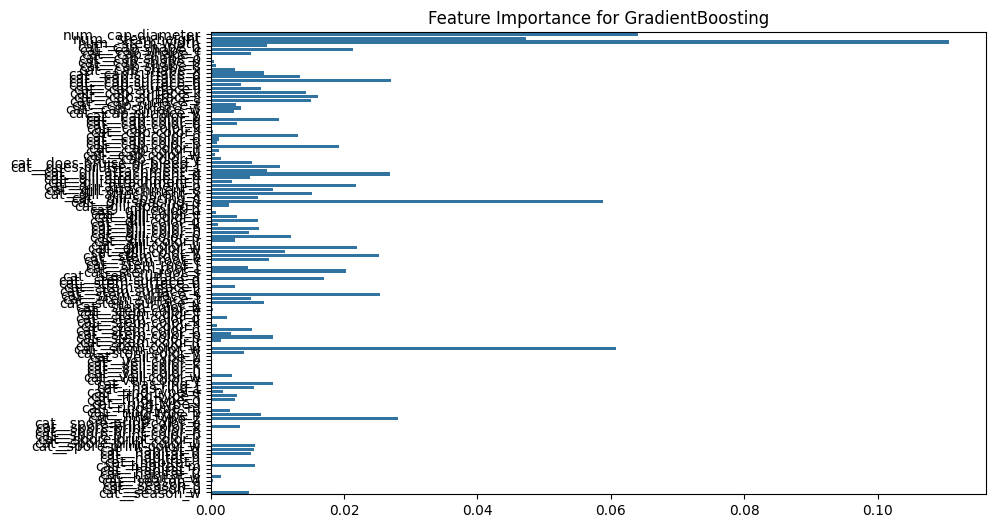


Evaluating XGBoost...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 0.9999999183854686

Evaluating AdaBoost...
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      5374
           1       0.89      0.85      0.87      6840

    accuracy                           0.86     12214
   macro avg       0.86      0.86      0.86     12214
weighted avg       0.86      0.86      0.86     12214

ROC-AUC Score: 0.942041086931446


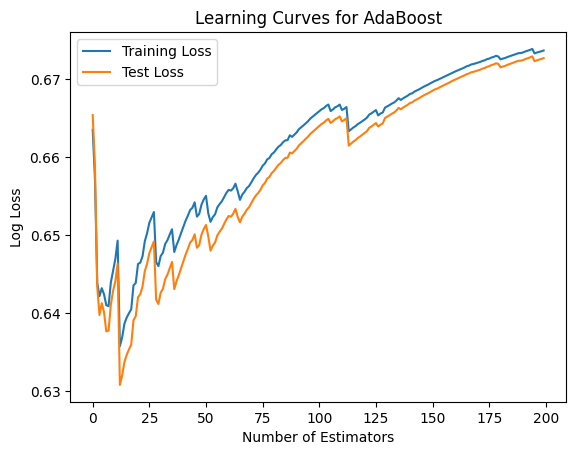

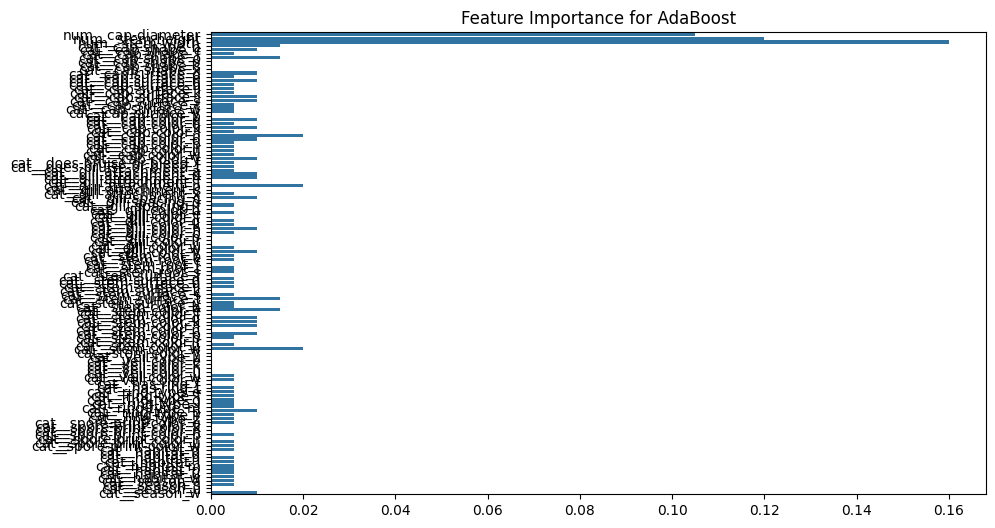


Evaluating ExtraTrees...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 1.0


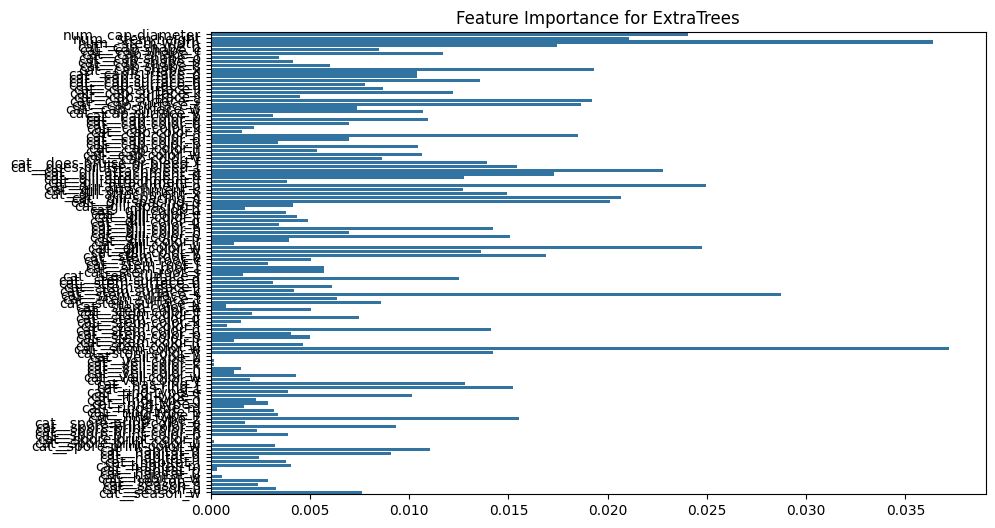


Evaluating SVC...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 0.9999997007467185

Evaluating LogisticRegression...
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      5374
           1       0.88      0.83      0.86      6840

    accuracy                           0.84     12214
   macro avg       0.84      0.84      0.84     12214
weighted avg       0.85      0.84      0.84     12214

ROC-AUC Score: 0.9131177675922842


DimensionError: The passed data does not match the background shape expected by the masker! The data of shape (1, 119) was passed while the masker expected data of shape (119,).

In [12]:
# Explicitly Train Models with Best Parameters
trained_models = {}
for model_name, params in best_params.items():
    print(f"Training {model_name} with best parameters...")
    if model_name == 'XGBoost':
        # Use native XGBoost API for early stopping
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        xgb_params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            **params
        }
        eval_set = [(dtrain, 'train'), (dtest, 'eval')]
        best_model = xgb.train(
            params=xgb_params,
            dtrain=dtrain,
            num_boost_round=params.get('n_estimators', 100),
            early_stopping_rounds=10,
            evals=eval_set,
            verbose_eval=True
        )
        trained_models[model_name] = best_model
    else:
        model = models[model_name].set_params(**params)
        model.fit(X_train, y_train)
        trained_models[model_name] = model

# Evaluation
for model_name, model in trained_models.items():
    print(f"\nEvaluating {model_name}...")
    if model_name == 'XGBoost':
        dtest = xgb.DMatrix(X_test, label=y_test)
        y_proba = model.predict(dtest)
        y_pred = (y_proba > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

    # Learning Curves (if applicable)
    if hasattr(model, 'staged_predict_proba'):
        train_losses = []
        test_losses = []
        for train_proba, test_proba in zip(model.staged_predict_proba(X_train), model.staged_predict_proba(X_test)):
            train_losses.append(log_loss(y_train, train_proba))
            test_losses.append(log_loss(y_test, test_proba))

        plt.plot(train_losses, label="Training Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.title(f"Learning Curves for {model_name}")
        plt.xlabel("Number of Estimators")
        plt.ylabel("Log Loss")
        plt.legend()
        plt.show()

    # Feature Importance (if applicable)
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        sns.barplot(x=model.feature_importances_, y=preprocessor.get_feature_names_out())
        plt.title(f"Feature Importance for {model_name}")
        plt.show()

# SHAP Analysis (Example with XGBoost)
xgb_model = trained_models['XGBoost']
dtest = xgb.DMatrix(X_test)
explainer = shap.Explainer(xgb_model.predict, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=preprocessor.get_feature_names_out())

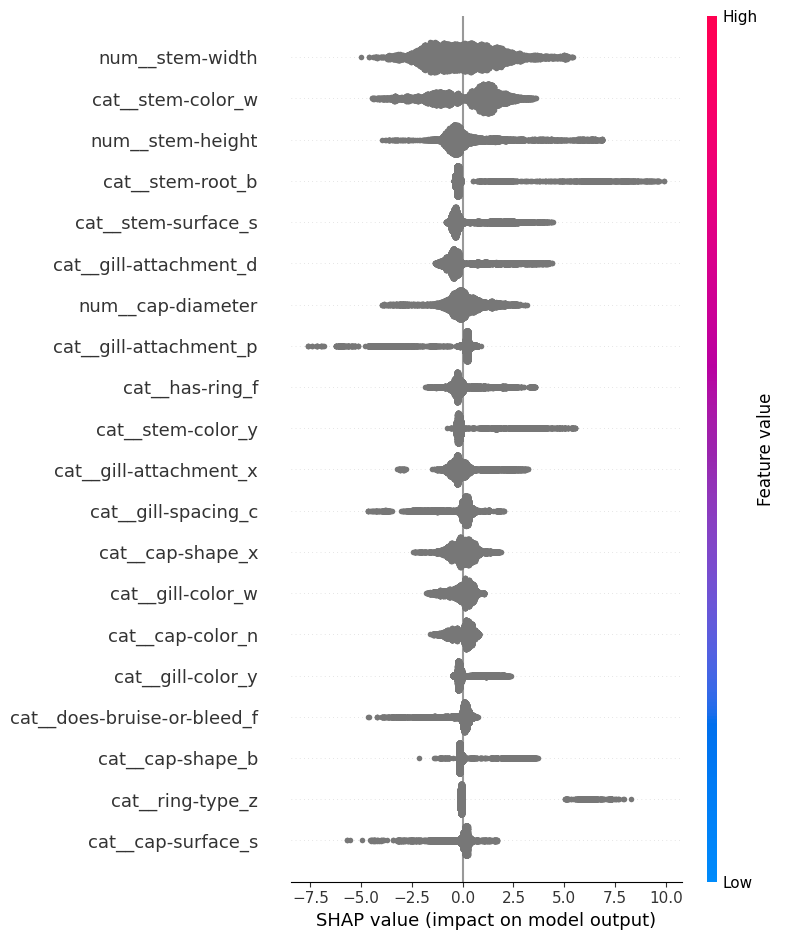

In [15]:
# SHAP Analysis (Example with XGBoost)
xgb_model = trained_models['XGBoost']

# Convert X_test to DMatrix
dtest = xgb.DMatrix(X_test)

# Initialize SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(dtest)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=preprocessor.get_feature_names_out())



Evaluating RandomForest...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 1.0


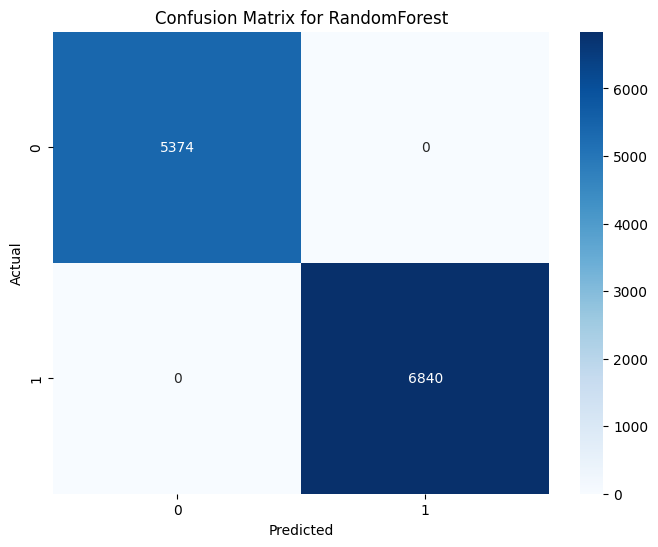

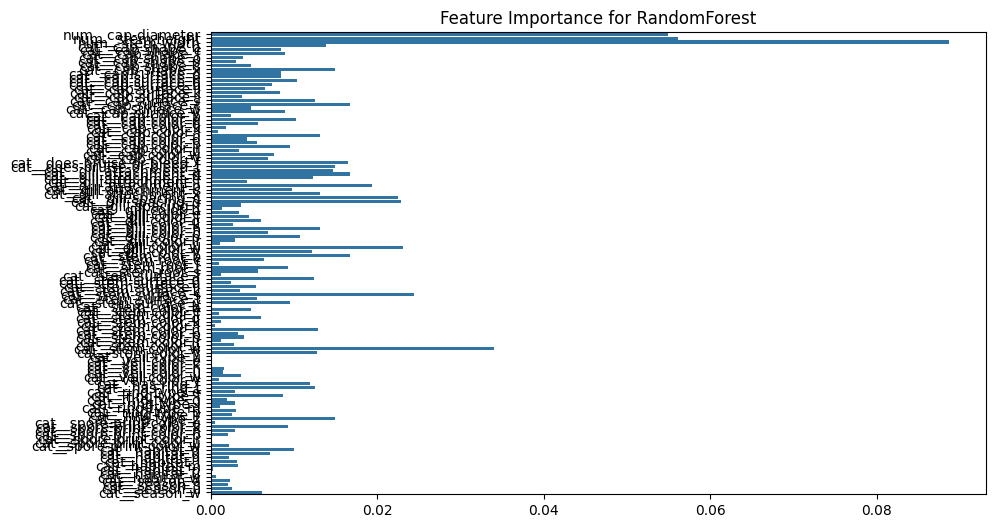


Evaluating GradientBoosting...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 1.0


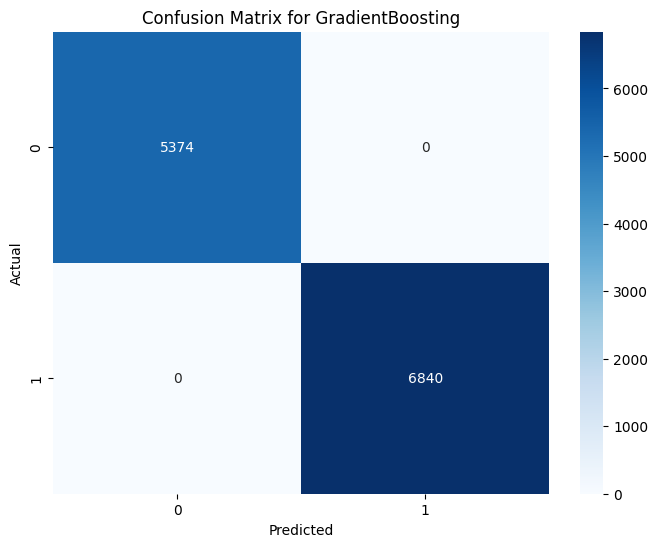

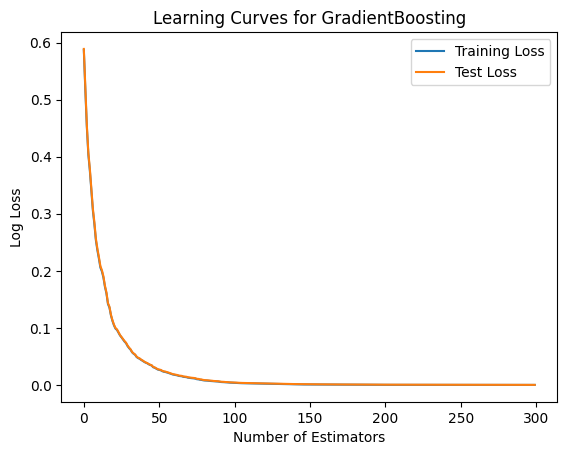

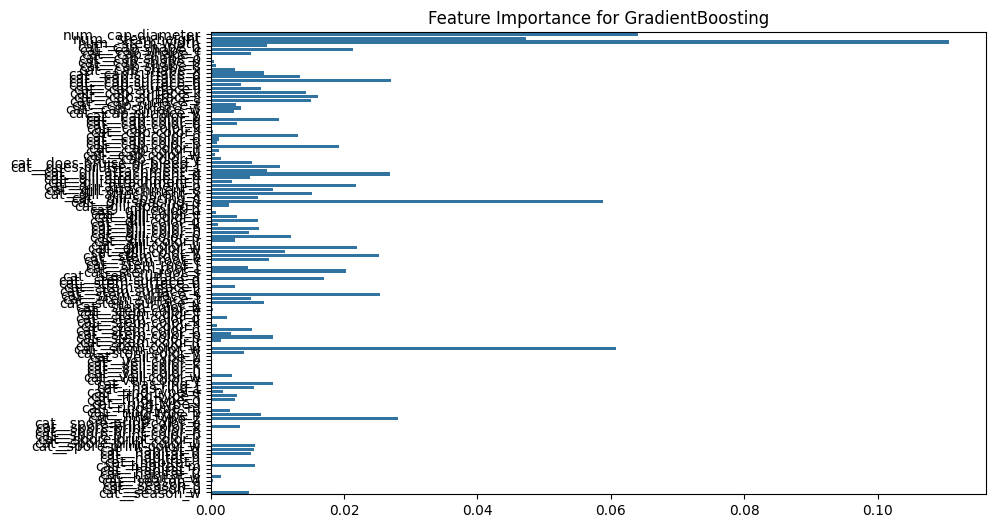


Evaluating XGBoost...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 0.9999999183854686


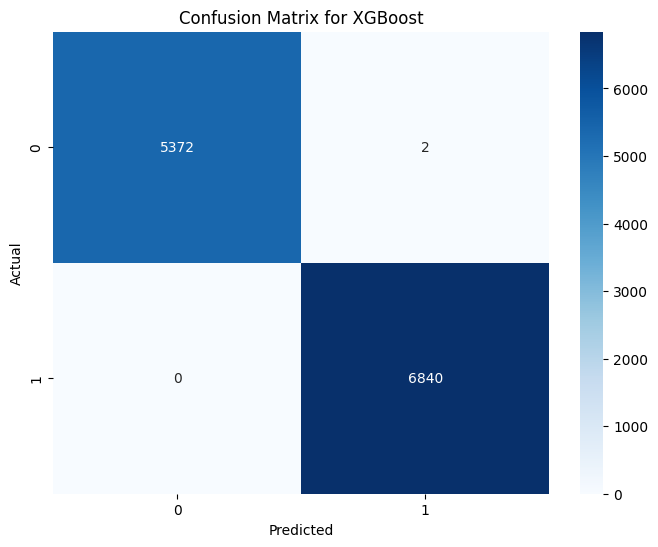


Evaluating AdaBoost...
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      5374
           1       0.89      0.85      0.87      6840

    accuracy                           0.86     12214
   macro avg       0.86      0.86      0.86     12214
weighted avg       0.86      0.86      0.86     12214

ROC-AUC Score: 0.942041086931446


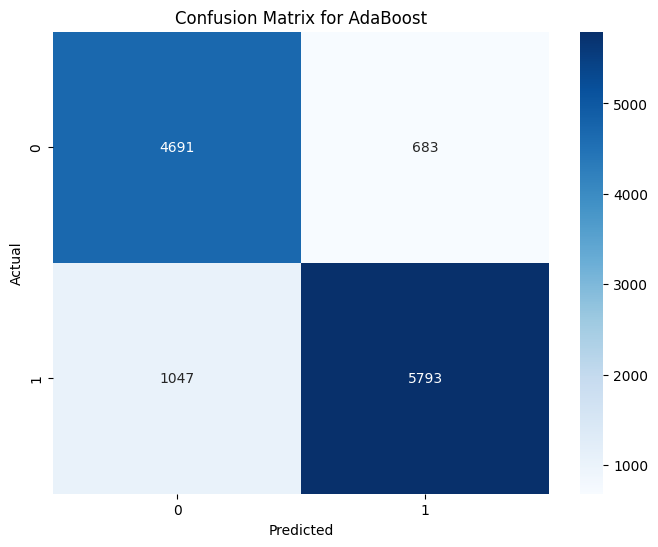

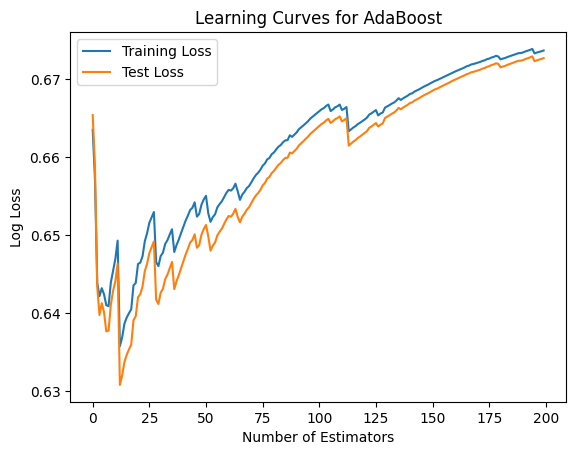

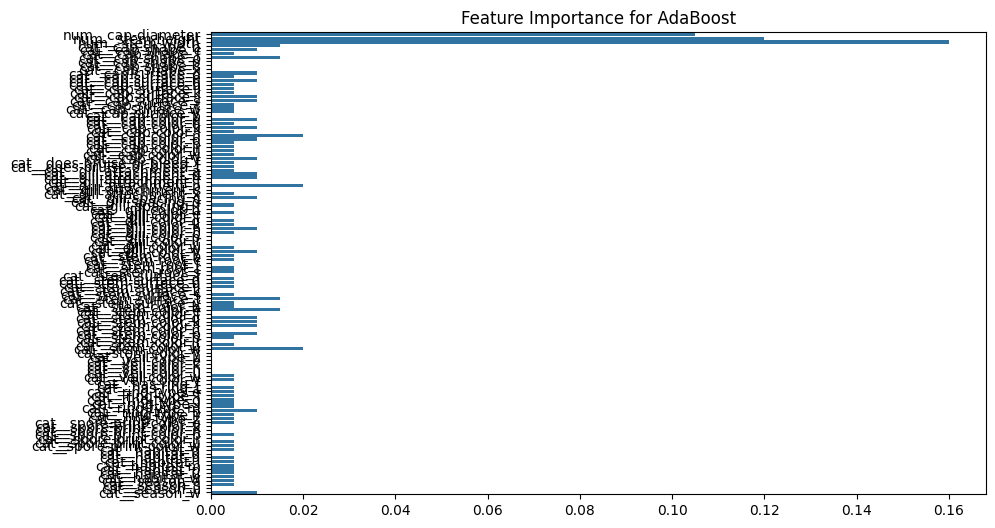


Evaluating ExtraTrees...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 1.0


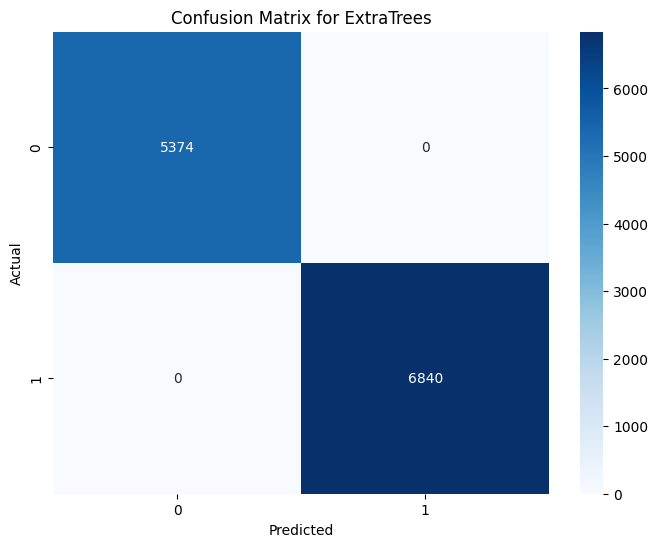

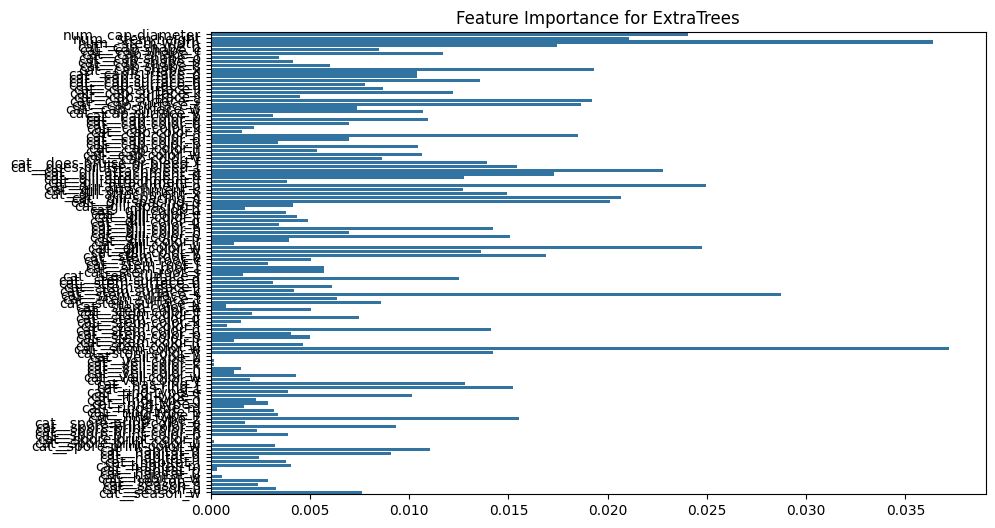


Evaluating SVC...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 0.9999997007467185


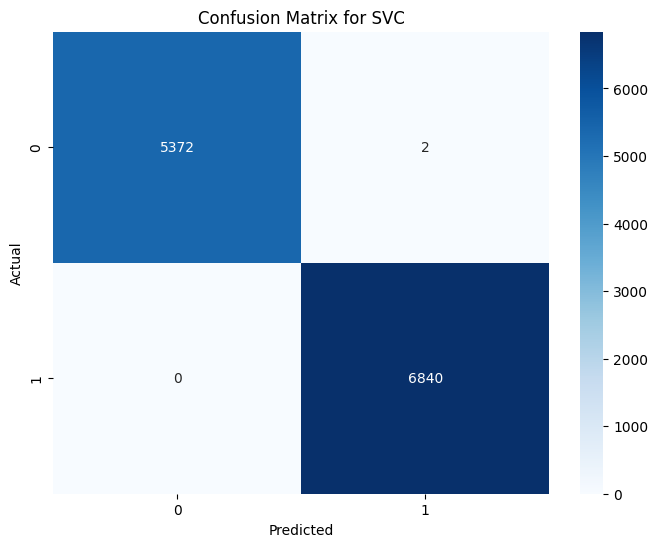


Evaluating LogisticRegression...
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      5374
           1       0.88      0.83      0.86      6840

    accuracy                           0.84     12214
   macro avg       0.84      0.84      0.84     12214
weighted avg       0.85      0.84      0.84     12214

ROC-AUC Score: 0.9131177675922842


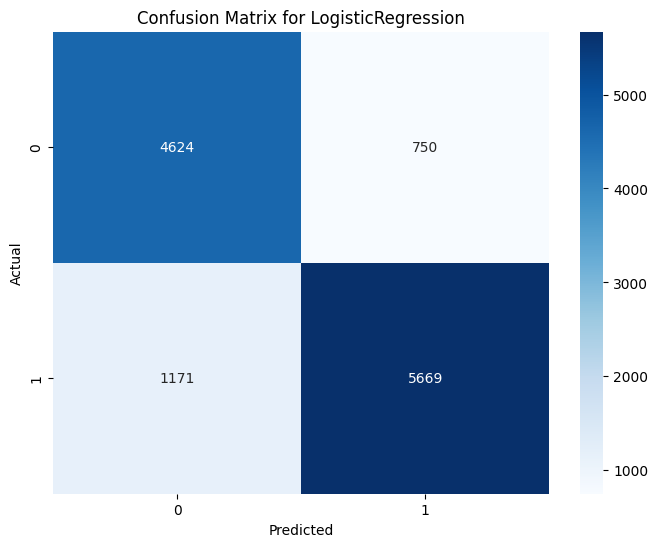

In [16]:
# Evaluation
for model_name, model in trained_models.items():
    print(f"\nEvaluating {model_name}...")
    if model_name == 'XGBoost':
        dtest = xgb.DMatrix(X_test, label=y_test)
        y_proba = model.predict(dtest)
        y_pred = (y_proba > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Learning Curves (if applicable)
    if hasattr(model, 'staged_predict_proba'):
        train_losses = []
        test_losses = []
        for train_proba, test_proba in zip(model.staged_predict_proba(X_train), model.staged_predict_proba(X_test)):
            train_losses.append(log_loss(y_train, train_proba))
            test_losses.append(log_loss(y_test, test_proba))

        plt.plot(train_losses, label="Training Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.title(f"Learning Curves for {model_name}")
        plt.xlabel("Number of Estimators")
        plt.ylabel("Log Loss")
        plt.legend()
        plt.show()

    # Feature Importance (if applicable)
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        sns.barplot(x=model.feature_importances_, y=preprocessor.get_feature_names_out())
        plt.title(f"Feature Importance for {model_name}")
        plt.show()

Training and evaluating RandomForest with updated parameters...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 1.0


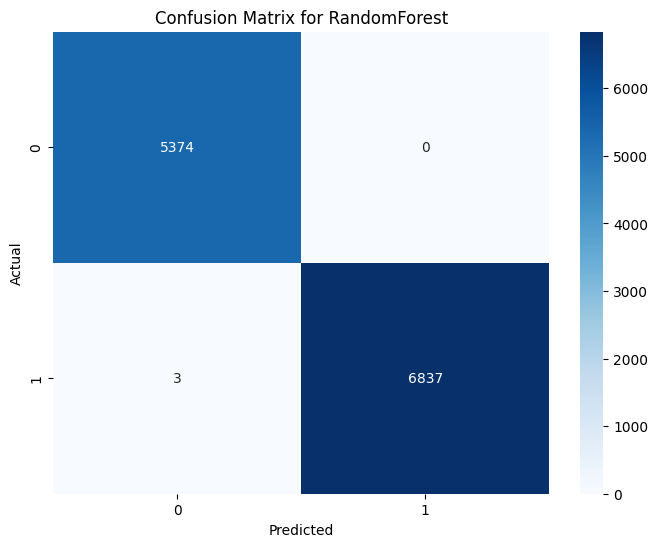

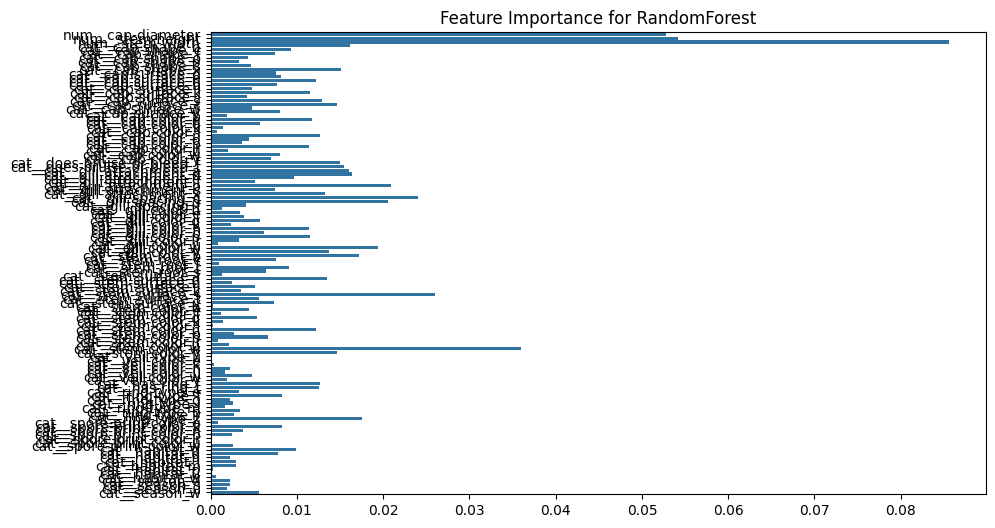

Training and evaluating GradientBoosting with updated parameters...
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5374
           1       1.00      0.99      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 0.9998705865581955


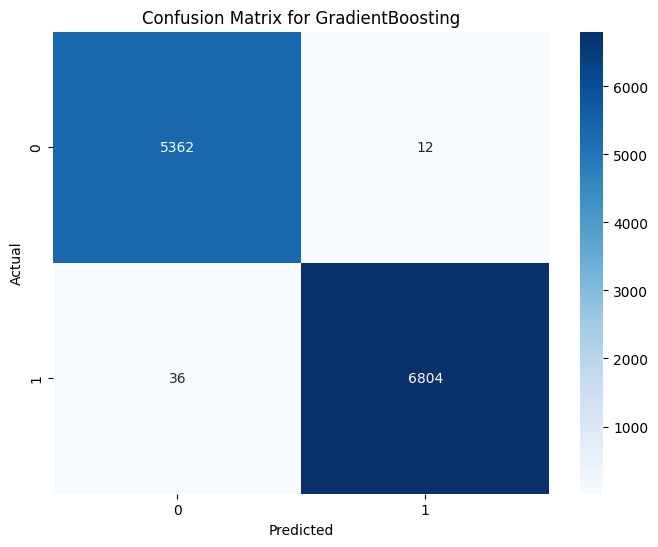

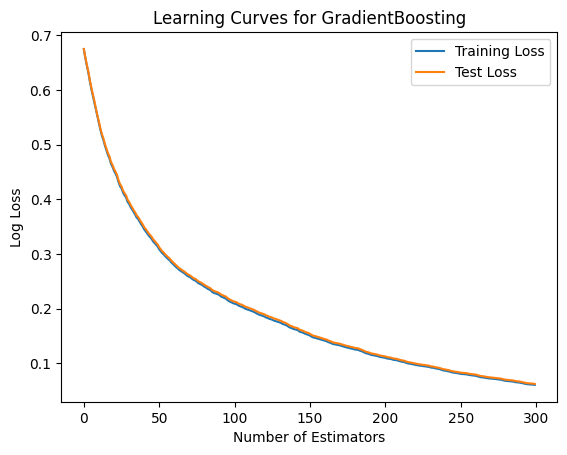

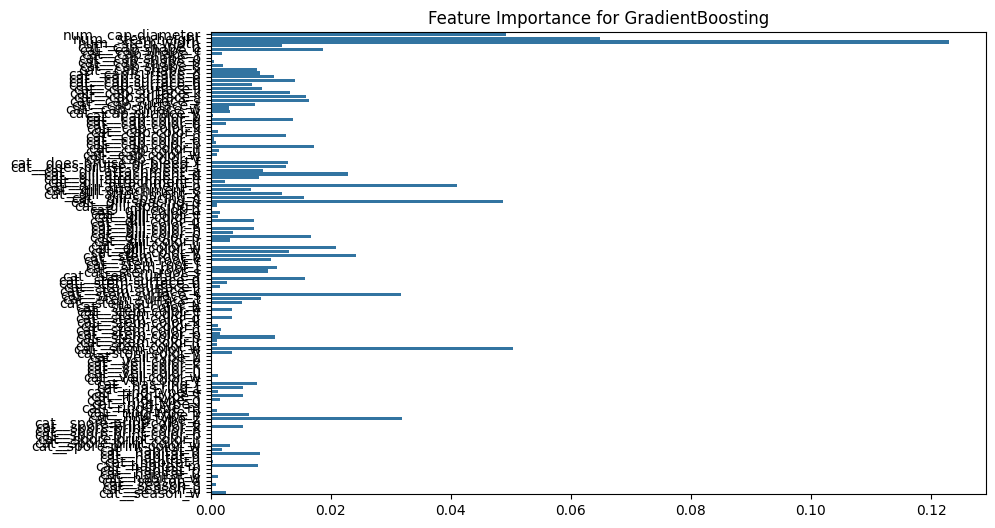

Training and evaluating XGBoost with updated parameters...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 0.9999724686981069


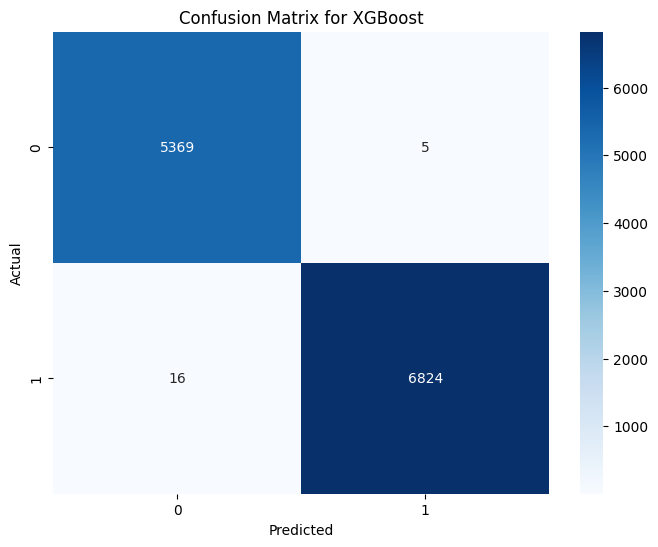

Training and evaluating ExtraTrees with updated parameters...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5374
           1       1.00      0.98      0.99      6840

    accuracy                           0.99     12214
   macro avg       0.99      0.99      0.99     12214
weighted avg       0.99      0.99      0.99     12214

ROC-AUC Score: 0.9997357321476374


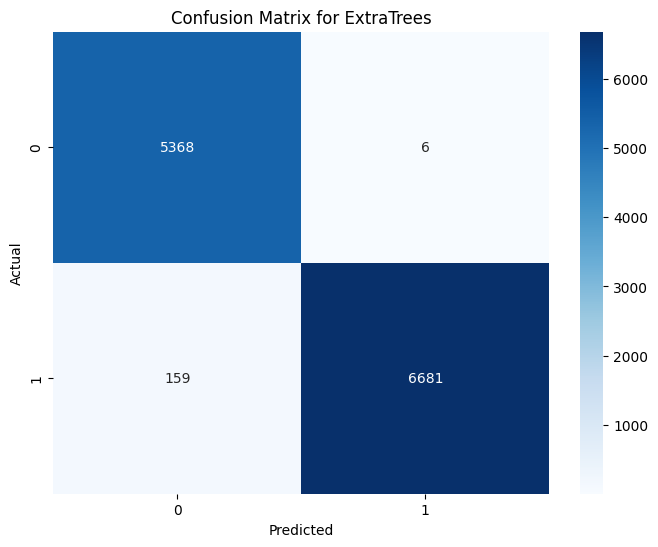

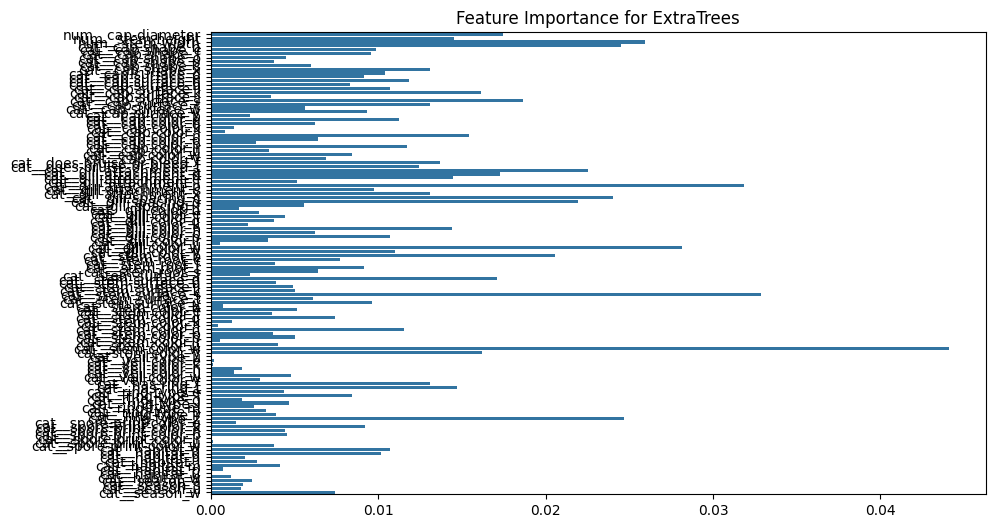

Training and evaluating SVC with updated parameters...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 0.9999929539454641


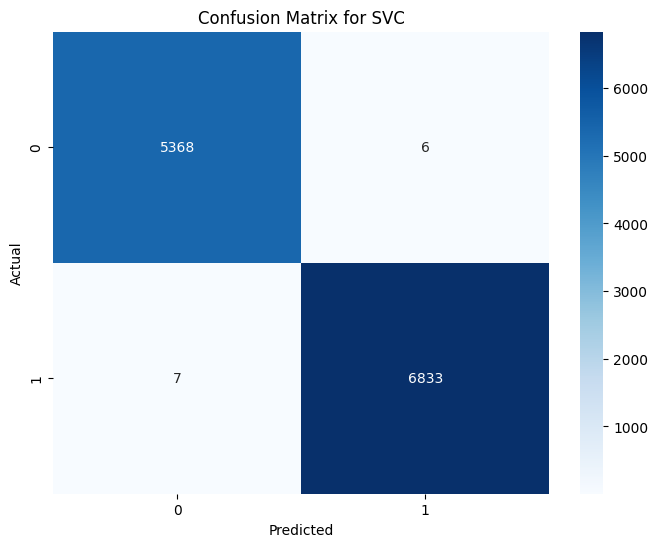

In [22]:
# Necessary libraries are already imported in your code

# Update the models with overfitting mitigation strategies
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Define updated hyperparameters and regularization techniques
updated_models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=10,
        max_features='sqrt',
        random_state=42
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        min_samples_split=10,
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1,
        reg_alpha=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    'ExtraTrees': ExtraTreesClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        max_features='sqrt',
        random_state=42
    ),
    'SVC': SVC(
        C=1,
        kernel='rbf',
        probability=True,
        random_state=42
    )
}

# Train models and evaluate
for model_name, model in updated_models.items():
    print(f"Training and evaluating {model_name} with updated parameters...")

    if model_name == 'XGBoost':
        # Use the DMatrix API for early stopping
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        xgb_params = model.get_params()

        evals = [(dtrain, 'train'), (dtest, 'eval')]

        # Train using xgboost.train for early stopping
        xgb_model = xgb.train(
            params=xgb_params,
            dtrain=dtrain,
            num_boost_round=xgb_params['n_estimators'],
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False
        )

        # Predictions for XGBoost
        y_proba = xgb_model.predict(dtest)
        y_pred = (y_proba > 0.5).astype(int)
    else:
        # Train and predict for other models
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluation metrics
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Learning Curves (for models supporting staged prediction)
    if hasattr(model, 'staged_predict_proba'):
        train_losses = []
        test_losses = []
        for train_proba, test_proba in zip(model.staged_predict_proba(X_train), model.staged_predict_proba(X_test)):
            train_losses.append(log_loss(y_train, train_proba))
            test_losses.append(log_loss(y_test, test_proba))

        plt.plot(train_losses, label="Training Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.title(f"Learning Curves for {model_name}")
        plt.xlabel("Number of Estimators")
        plt.ylabel("Log Loss")
        plt.legend()
        plt.show()

    # Feature Importance (for tree-based models)
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        sns.barplot(x=model.feature_importances_, y=preprocessor.get_feature_names_out())
        plt.title(f"Feature Importance for {model_name}")
        plt.show()


Training and evaluating RandomForest with updated parameters...
Cross-validation ROC-AUC for RandomForest: 1.0000 ± 0.0000
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5374
           1       1.00      0.98      0.99      6840

    accuracy                           0.99     12214
   macro avg       0.99      0.99      0.99     12214
weighted avg       0.99      0.99      0.99     12214

ROC-AUC Score: 0.999980412512487
Out-of-Bag Score for RandomForest: 0.9905


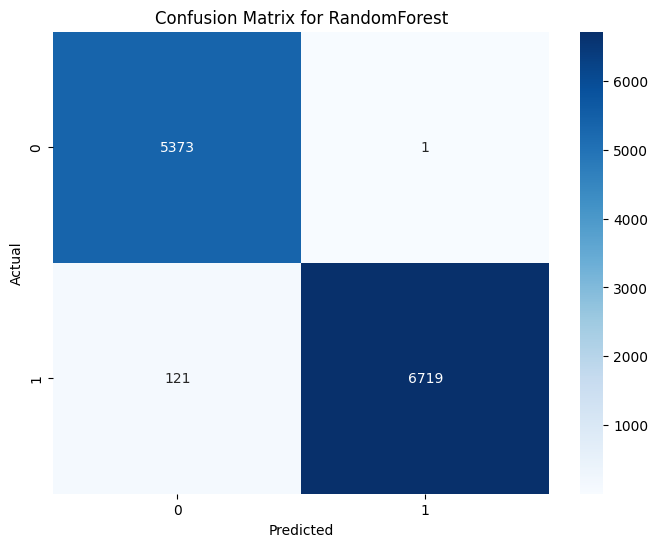

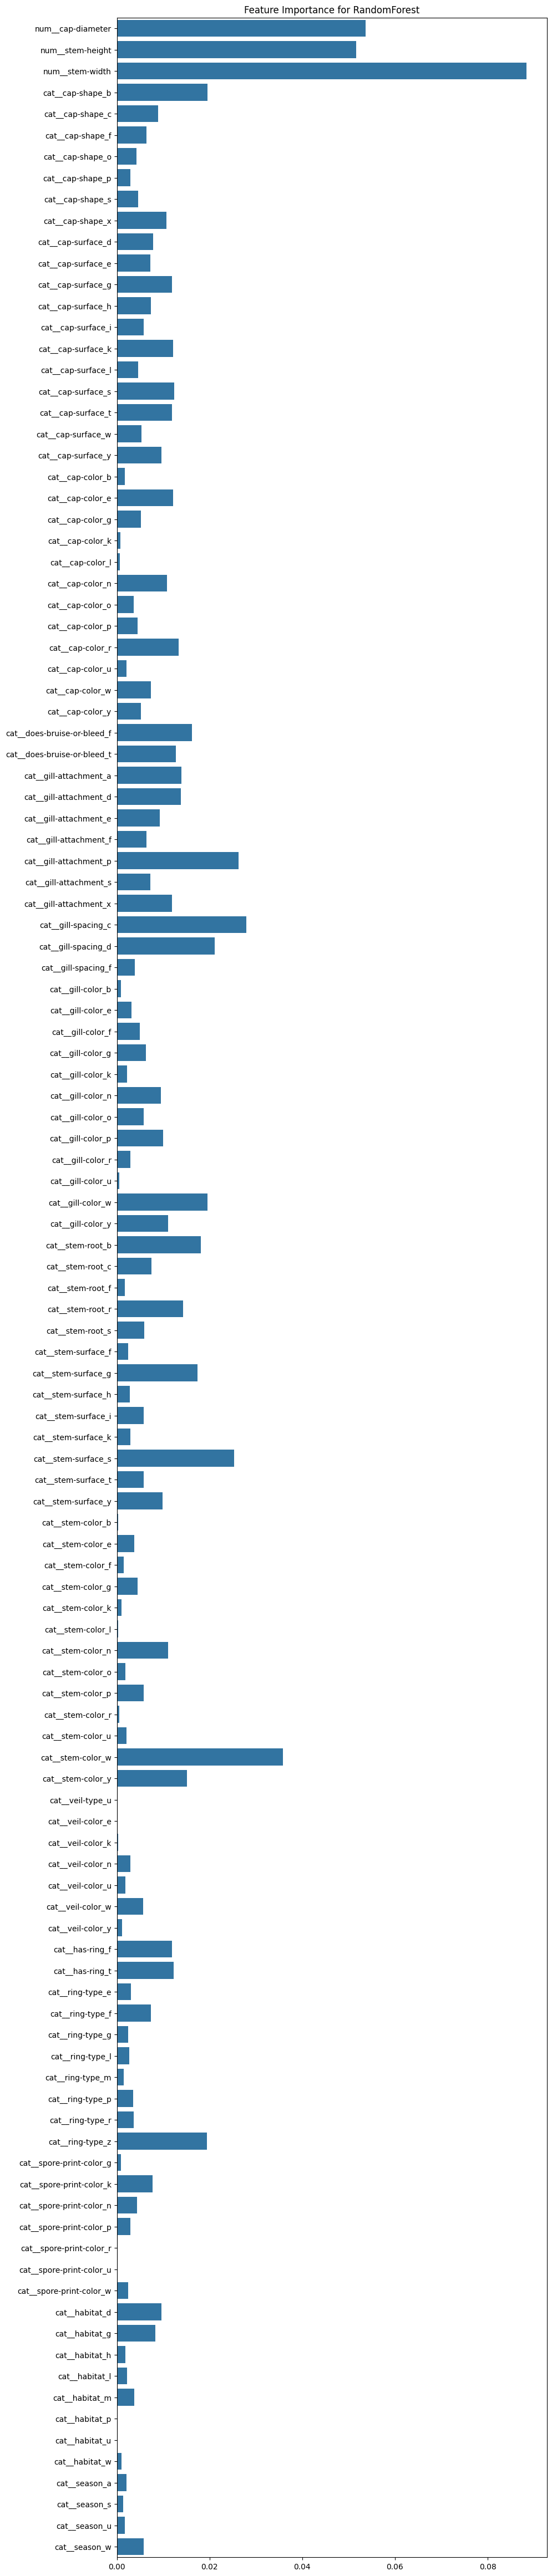

Training and evaluating GradientBoosting with updated parameters...
Cross-validation ROC-AUC for GradientBoosting: 0.9999 ± 0.0001


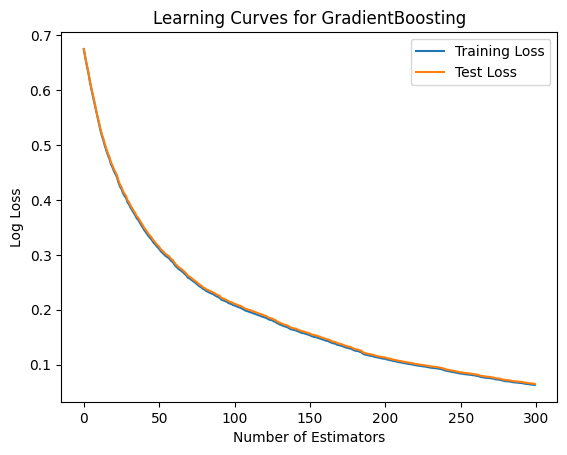

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 0.9998516519869329


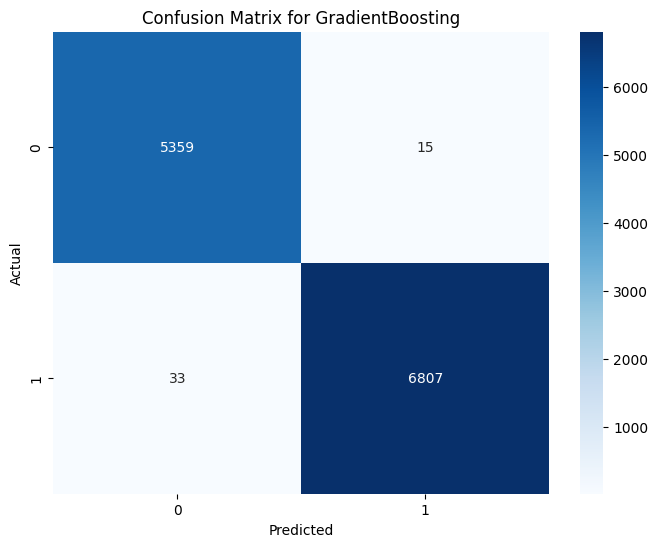

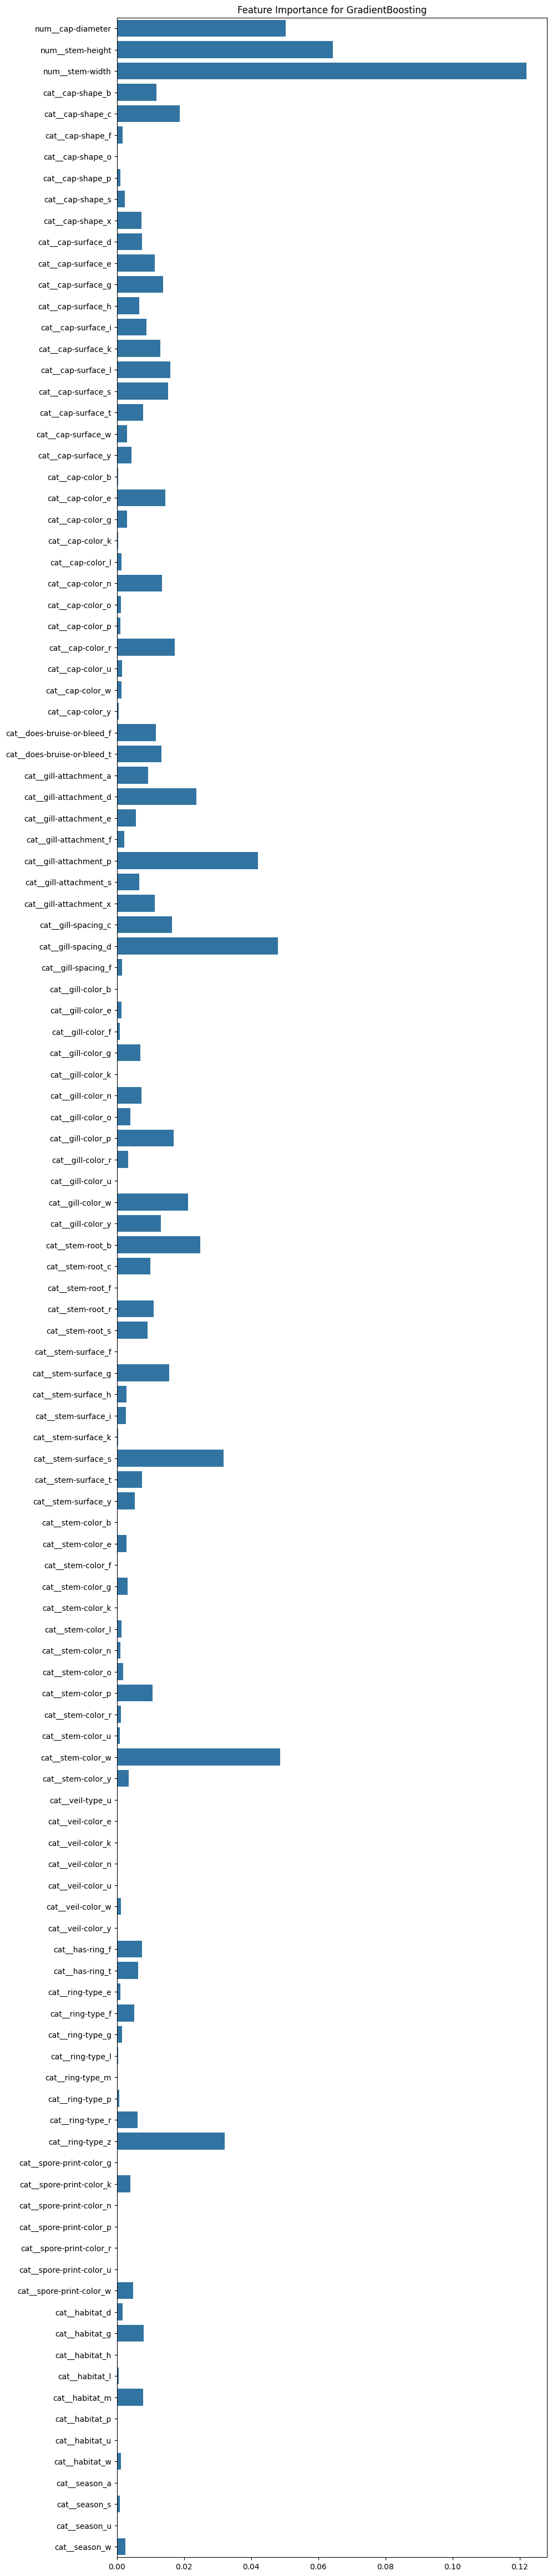

Training and evaluating XGBoost with updated parameters...
Cross-validation logloss for XGBoost: 0.03922575617394189


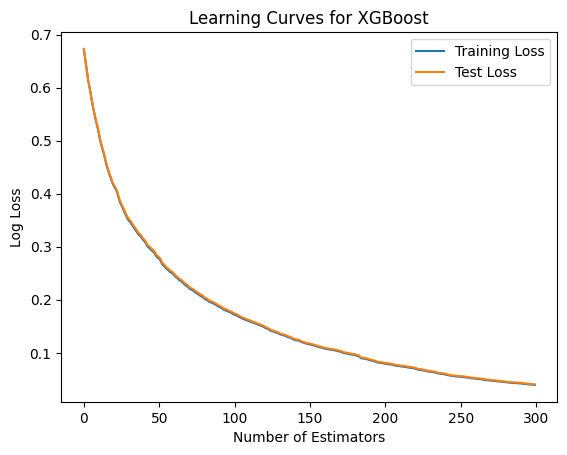

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 0.9999672453681032


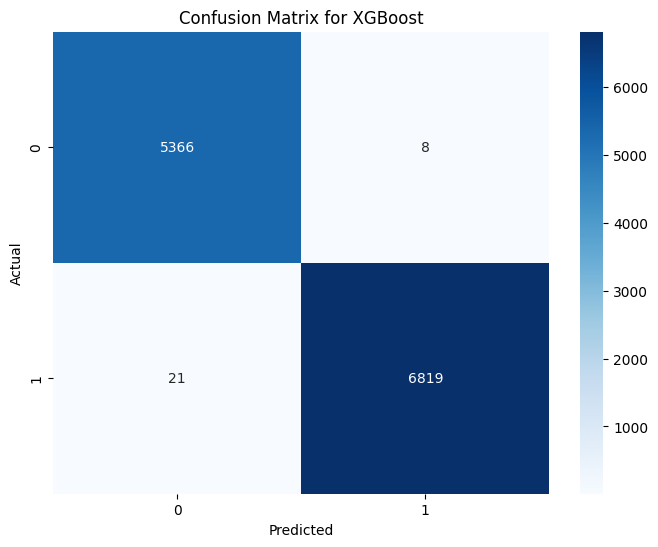

Training and evaluating ExtraTrees with updated parameters...
Cross-validation ROC-AUC for ExtraTrees: 0.9996 ± 0.0001
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5374
           1       1.00      0.98      0.99      6840

    accuracy                           0.99     12214
   macro avg       0.98      0.99      0.99     12214
weighted avg       0.99      0.99      0.99     12214

ROC-AUC Score: 0.9996757182622852


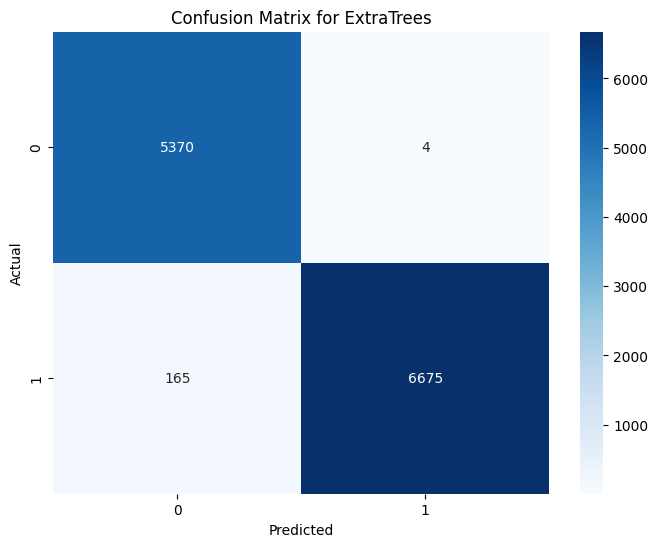

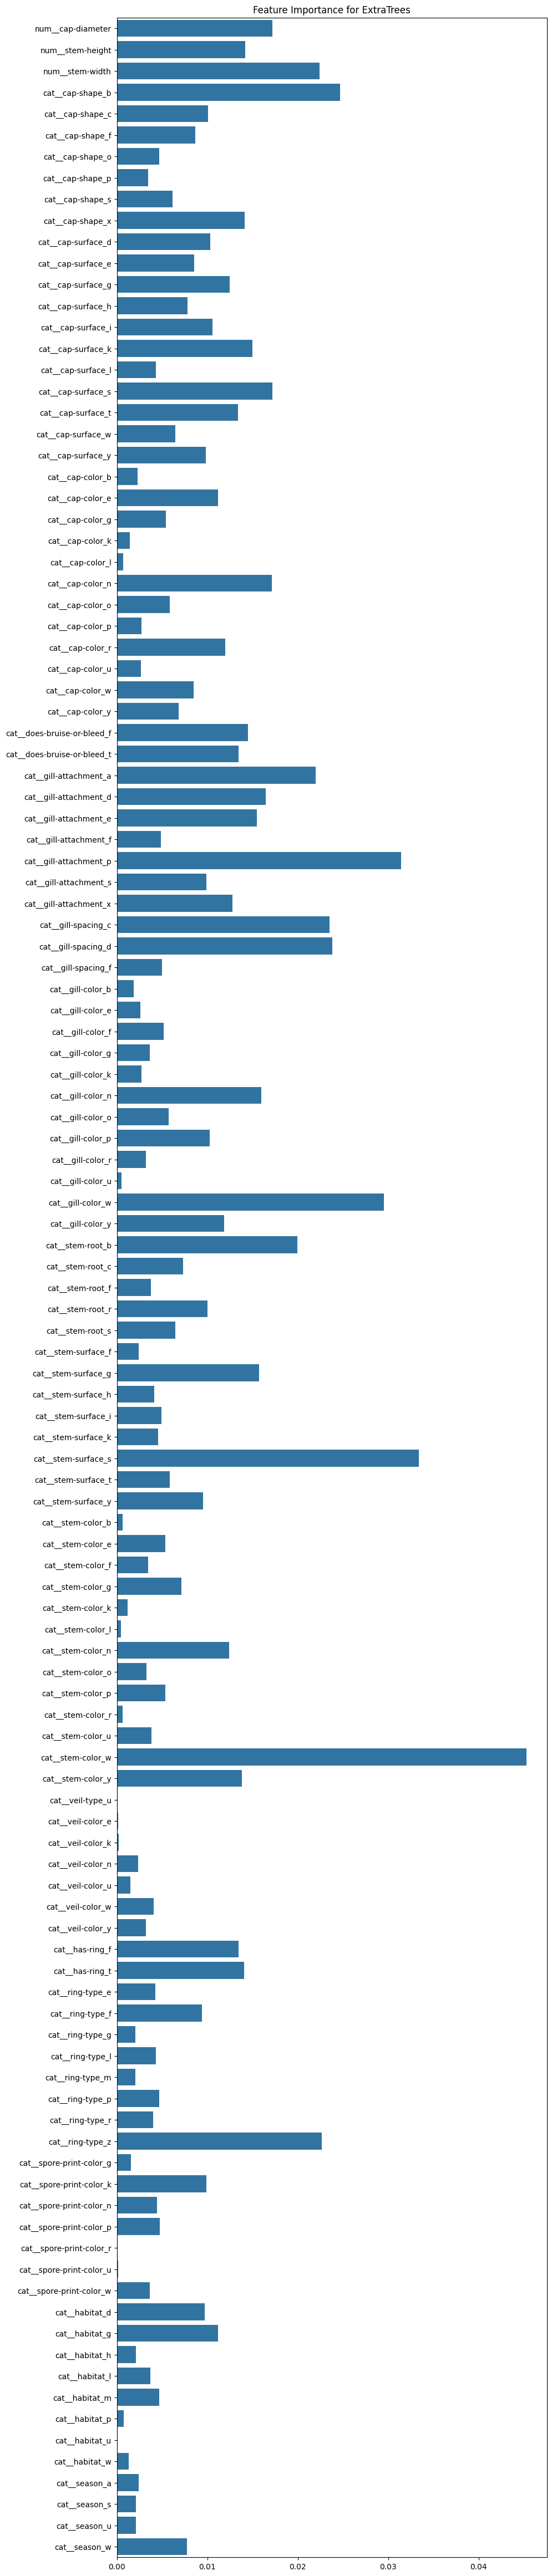

Training and evaluating SVC with updated parameters...
Cross-validation ROC-AUC for SVC: 1.0000 ± 0.0001
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5374
           1       1.00      1.00      1.00      6840

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC Score: 0.9999929539454641


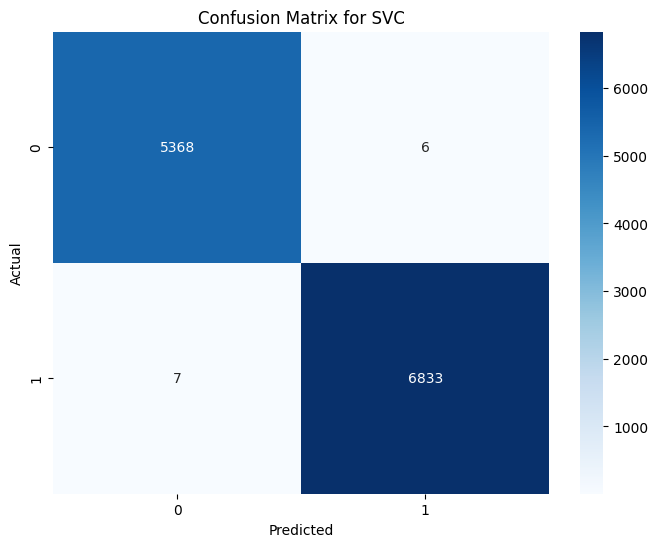

Running permutation test for RandomForest...
ROC-AUC on shuffled data: 0.47922885693952033
Running permutation test for GradientBoosting...
ROC-AUC on shuffled data: 0.492190958415764
Running permutation test for XGBoost...
ROC-AUC on shuffled data: 0.4772813437886989
Running permutation test for ExtraTrees...
ROC-AUC on shuffled data: 0.48103882240025064
Running permutation test for SVC...
ROC-AUC on shuffled data: 0.5


In [28]:
# Necessary libraries are already imported in previous code

# Update the models with overfitting mitigation strategies
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.utils import shuffle

# Define updated hyperparameters and regularization techniques
updated_models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        max_depth=15,  # Reduced depth for regularization
        min_samples_split=10,
        min_samples_leaf=5,  # Added minimum leaf samples for regularization
        max_features='sqrt',
        random_state=42,
        oob_score=True  # Enable OOB score for staged predictions
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        min_samples_split=10,
        min_samples_leaf=5,  # Added minimum leaf samples for regularization
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=2,  # Increased L2 regularization
        reg_alpha=1,  # Added L1 regularization
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    'ExtraTrees': ExtraTreesClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,  # Added minimum leaf samples for regularization
        max_features='sqrt',
        random_state=42
    ),
    'SVC': SVC(
        C=1,
        kernel='rbf',
        probability=True,
        random_state=42
    )
}

# Train models and evaluate
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in updated_models.items():
    print(f"Training and evaluating {model_name} with updated parameters...")

    if model_name == 'XGBoost':
        # Use the DMatrix API for early stopping
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        xgb_params = model.get_params()

        evals = [(dtrain, 'train'), (dtest, 'eval')]

        # Train using xgboost.train for early stopping
        xgb_model = xgb.train(
            params=xgb_params,
            dtrain=dtrain,
            num_boost_round=xgb_params['n_estimators'],
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False
        )

        # Cross-validation for XGBoost
        cv_results = xgb.cv(
            params=xgb_params,
            dtrain=dtrain,
            num_boost_round=xgb_params['n_estimators'],
            nfold=5,
            metrics=['logloss'],
            early_stopping_rounds=10,
            seed=42
        )
        print(f"Cross-validation logloss for {model_name}: {cv_results['test-logloss-mean'].iloc[-1]}")

        # Predictions for XGBoost
        y_proba = xgb_model.predict(dtest)
        y_pred = (y_proba > 0.5).astype(int)

        # Learning Curves for XGBoost
        train_losses = []
        test_losses = []
        for i in range(1, xgb_params['n_estimators'] + 1):
            y_train_pred = xgb_model.predict(dtrain, iteration_range=(0, i))
            y_test_pred = xgb_model.predict(dtest, iteration_range=(0, i))
            train_losses.append(log_loss(y_train, y_train_pred))
            test_losses.append(log_loss(y_test, y_test_pred))

        plt.plot(train_losses, label="Training Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.title(f"Learning Curves for {model_name}")
        plt.xlabel("Number of Estimators")
        plt.ylabel("Log Loss")
        plt.legend()
        plt.show()
    else:
        # Cross-validation for other models
        cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
        print(f"Cross-validation ROC-AUC for {model_name}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

        # Train and predict for other models
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Learning Curves for GradientBoosting
        if model_name == 'GradientBoosting':
            train_losses = []
            test_losses = []
            for train_proba, test_proba in zip(model.staged_predict_proba(X_train), model.staged_predict_proba(X_test)):
                train_losses.append(log_loss(y_train, train_proba))
                test_losses.append(log_loss(y_test, test_proba))

            plt.plot(train_losses, label="Training Loss")
            plt.plot(test_losses, label="Test Loss")
            plt.title(f"Learning Curves for {model_name}")
            plt.xlabel("Number of Estimators")
            plt.ylabel("Log Loss")
            plt.legend()
            plt.show()

    # Evaluation metrics
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

    # Out-of-Bag Score for RandomForest
    if model_name == 'RandomForest' and model.oob_score:
        print(f"Out-of-Bag Score for {model_name}: {model.oob_score_:.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Feature Importance (for tree-based models)
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, len(preprocessor.get_feature_names_out()) / 2))  # Adjust height dynamically
        sns.barplot(x=model.feature_importances_, y=preprocessor.get_feature_names_out())
        plt.title(f"Feature Importance for {model_name}")
        plt.show()

# Permutation Test
for model_name, model in updated_models.items():
    print(f"Running permutation test for {model_name}...")

    # Shuffle target labels
    y_train_shuffled = shuffle(y_train, random_state=42)

    if model_name == 'XGBoost':
        # Train XGBoost on shuffled data
        dtrain_shuffled = xgb.DMatrix(X_train, label=y_train_shuffled)
        evals = [(dtrain_shuffled, 'train')]

        xgb_model_shuffled = xgb.train(
            params=xgb_params,
            dtrain=dtrain_shuffled,
            num_boost_round=xgb_params['n_estimators'],
            evals=evals,
            verbose_eval=False
        )

        # Predictions for XGBoost with shuffled labels
        y_proba_shuffled = xgb_model_shuffled.predict(dtest)
        print("ROC-AUC on shuffled data:", roc_auc_score(y_test, y_proba_shuffled))
    else:
        # Train and evaluate on shuffled labels for other models
        model.fit(X_train, y_train_shuffled)
        y_pred_shuffled = model.predict(X_test)
        y_proba_shuffled = model.predict_proba(X_test)[:, 1]

        print("ROC-AUC on shuffled data:", roc_auc_score(y_test, y_proba_shuffled))
